<a href="https://colab.research.google.com/github/Aderonke25/Machine-Learning-Zoomcamp-2025/blob/main/DataTalksModule4Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import KFold

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [3]:
df = pd.read_csv(url)

df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
# Fill missing values
categorical_cols = ['lead_source', 'industry', 'employment_status', 'location']
numerical_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']

df[categorical_cols] = df[categorical_cols].fillna('NA')
df[numerical_cols] = df[numerical_cols].fillna(0.0)
print(df)

         lead_source       industry  number_of_courses_viewed  annual_income  \
0           paid_ads             NA                         1        79450.0   
1       social_media         retail                         1        46992.0   
2             events     healthcare                         5        78796.0   
3           paid_ads         retail                         2        83843.0   
4           referral      education                         3        85012.0   
...              ...            ...                       ...            ...   
1457        referral  manufacturing                         1            0.0   
1458        referral     technology                         3        65259.0   
1459        paid_ads     technology                         1        45688.0   
1460        referral             NA                         5        71016.0   
1461  organic_search        finance                         3        92855.0   

     employment_status       location  

In [5]:
# Split 60% train, 40% temp
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=1)

# Split temp into 20% validation and 20% test (each 50% of 40%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1)

# Check the sizes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (877, 9)
Validation shape: (292, 9)
Test shape: (293, 9)


#Question 1

In [6]:
# Define target and numerical features
target = 'converted'
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# STEP 4: Compute AUC for each numerical variable

print("AUC scores before inversion:\n")

for col in numerical_features:
    # Extract y (target) and prediction (feature)
    y_true = train_df[target]
    y_pred = train_df[col]

    # Compute AUC
    auc_value = roc_auc_score(y_true, y_pred)

    # Display initial AUC
    print(f"{col}: {auc_value:.3f}")

    # If AUC < 0.5, invert the variable
    if auc_value < 0.5:
        print(f" → AUC < 0.5 detected for {col}. Inverting variable...")
        train_df[col] = -train_df[col]
        auc_value = roc_auc_score(y_true, train_df[col])
        print(f" → New AUC after inversion: {auc_value:.3f}")

    print("-" * 40)

# STEP 5: Display final AUC summary
print("\nFinal AUC scores after checking inversion:\n")
for col in numerical_features:
    final_auc = roc_auc_score(train_df[target], train_df[col])
    print(f"{col}: {final_auc:.3f}")

AUC scores before inversion:

number_of_courses_viewed: 0.765
----------------------------------------
annual_income: 0.545
----------------------------------------
interaction_count: 0.727
----------------------------------------
lead_score: 0.611
----------------------------------------

Final AUC scores after checking inversion:

number_of_courses_viewed: 0.765
annual_income: 0.545
interaction_count: 0.727
lead_score: 0.611


#Question 2


In [7]:
# Separate target and features
y_train = train_df['converted'].values
train_features = train_df.drop(columns=['converted'])

y_val = val_df['converted'].values
val_features = val_df.drop(columns=['converted'])

# Convert to dictionary format for DictVectorizer
train_dicts = train_features.to_dict(orient='records')
val_dicts = val_features.to_dict(orient='records')

# One-hot encode categorical variables
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities on validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Compute validation AUC
val_auc = roc_auc_score(y_val, y_pred)

print(f"Validation AUC: {val_auc:.3f}")

Validation AUC: 0.794


#Question 3


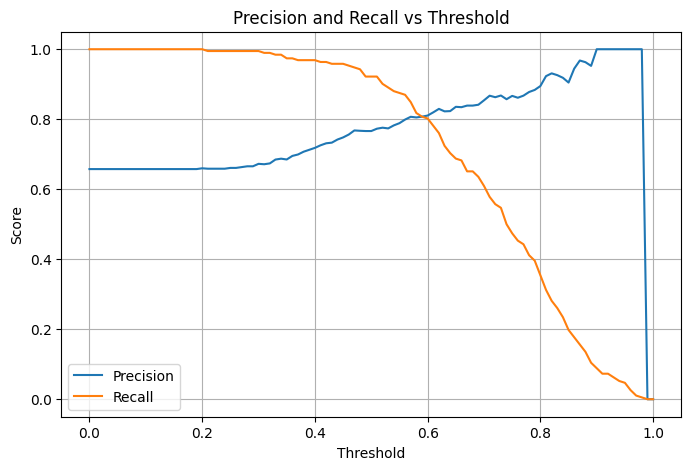

In [8]:
# Create thresholds from 0.0 to 1.0 (step 0.01)
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

# Loop through thresholds and compute precision, recall
for t in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_pred >= t).astype(int)

    # Compute precision and recall
    p = precision_score(y_val, y_pred_binary, zero_division=0)
    r = recall_score(y_val, y_pred_binary, zero_division=0)

    precisions.append(p)
    recalls.append(r)

# --------------------------------------------
# Plot Precision and Recall vs Threshold
# --------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

#Question 4


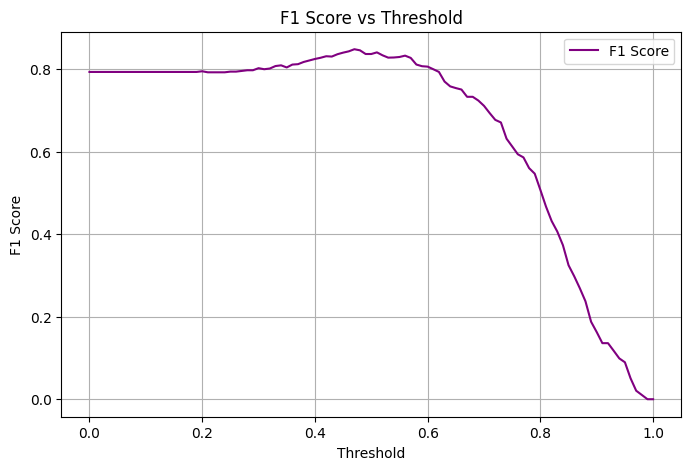

Best Threshold: 0.470
Best F1 Score: 0.848


In [9]:
# Compute F1-score for all thresholds
f1_scores = []

for p, r in zip(precisions, recalls):
    if (p + r) == 0:
        f1 = 0
    else:
        f1 = 2 * (p * r) / (p + r)
    f1_scores.append(f1)

# Plot F1 vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, color='purple', label='F1 Score')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1:.3f}")

#Question 5

In [10]:
# ✅ Define target and numerical features
target = 'converted'
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# ✅ Ensure df_full_train exists (combine train + val if needed)
df_full_train = pd.concat([train_df, val_df]).reset_index(drop=True)

# ✅ Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

# ✅ Iterate over 5 folds
for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train), 1):
    # Split train and validation sets
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    # -----------------------------
    # AUC correction for numeric features
    # -----------------------------
    for col in numerical_features:
        auc_value = roc_auc_score(df_train[target], df_train[col])
        if auc_value < 0.5:
            df_train[col] = -df_train[col]
            df_val[col] = -df_val[col]  # apply same inversion to val set

    # -----------------------------
    # Prepare data for DictVectorizer
    # -----------------------------
    y_train = df_train[target].values
    y_val = df_val[target].values

    train_dicts = df_train.drop(columns=[target]).to_dict(orient='records')
    val_dicts = df_val.drop(columns=[target]).to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    # -----------------------------
    # Train logistic regression
    # -----------------------------
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities for validation fold
    y_pred = model.predict_proba(X_val)[:, 1]

    # Compute AUC
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

    print(f"Fold {fold}: AUC = {auc:.3f}")

# ✅ Print average AUC across folds
print(f"\nAverage AUC across 5 folds: {np.mean(auc_scores):.3f}")

Fold 1: AUC = 0.807
Fold 2: AUC = 0.807
Fold 3: AUC = 0.865
Fold 4: AUC = 0.833
Fold 5: AUC = 0.815

Average AUC across 5 folds: 0.825


In [12]:
std=np.std([0.807,0.807,0.865,0.833,0.815])


In [13]:
print(std)

0.02195996357009727


#Question 6

In [14]:
#Candidate C values
C_values = [0.000001, 0.001, 1]

#Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

#Store results
results = []

for C in C_values:
    auc_scores = []

    # 5-Fold Cross Validation
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx].copy()
        df_val = df_full_train.iloc[val_idx].copy()

        # --- AUC inversion for numerical features ---
        for col in numerical_features:
            auc_value = roc_auc_score(df_train[target], df_train[col])
            if auc_value < 0.5:
                df_train[col] = -df_train[col]
                df_val[col] = -df_val[col]

        # --- Prepare data for DictVectorizer ---
        y_train = df_train[target].values
        y_val = df_val[target].values

        train_dicts = df_train.drop(columns=[target]).to_dict(orient='records')
        val_dicts = df_val.drop(columns=[target]).to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)

        # --- Train logistic regression with current C ---
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict probabilities and compute AUC
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    # Compute mean and std of AUC for this C
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    results.append((C, round(mean_auc, 3), round(std_auc, 3)))

# ✅ Display results
print("C-value | Mean AUC | Std AUC")
print("-----------------------------")
for C, mean_auc, std_auc in results:
    print(f"{C:<8} | {mean_auc:<8} | {std_auc:<8}")

C-value | Mean AUC | Std AUC
-----------------------------
1e-06    | 0.543    | 0.025   
0.001    | 0.864    | 0.014   
1        | 0.825    | 0.022   
